In [2]:
from transforms import Deslant
from torchvision.transforms import Compose
from dataset import CTCData
import cv2
import matplotlib.pyplot as plt

In [3]:
def show_img(img):
    cv2.imshow('', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def plot_img(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def bounding_box(x1,y1,x2,y2,img):
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return img

In [4]:
import pandas as pd
import os
df = pd.read_csv('../../Dataset/DIDA/DIDA_Label1.csv').astype(str)
word_df=df
chars = []
word_col=-1
word_df.iloc[:, word_col].apply(lambda x: chars.extend(list(x)))
# 
# chars = sorted(list(set(chars)))
# char_dict = {c:i for i, c in enumerate(chars, 1)}

0       None
1       None
2       None
3       None
4       None
        ... 
1855    None
1856    None
1857    None
1858    None
1859    None
Name: word, Length: 1860, dtype: object

In [6]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

In [7]:
path="../../Dataset/DIDA/DIDA_1/"
path2="../../Dataset/DIDA/DIDA_2/"

for filename in os.listdir(path):
    full_path=os.path.join(path,filename)
    img=cv2.imread(full_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh=thresholding(gray)
    cv2.imwrite(path2+filename,thresh)

In [3]:
dataset = CTCData(csv_file='DIDA_Label1.csv', 
                  root_dir='../../Dataset/DIDA/DIDA_2/',
                  transform=Compose([
                     Deslant()]))

In [21]:
dataset[102]

{'image': array([[255, 255, 255, ..., 140, 126, 188],
        [255, 255, 255, ..., 168, 245, 255],
        [255, 255, 255, ...,  50, 255, 255],
        ...,
        [255, 255, 168, ..., 255, 255, 255],
        [255, 128, 117, ..., 255, 255, 255],
        [227, 162, 165, ..., 255, 255, 255]], dtype=uint8),
 'word': '1830'}

/home/vuong/Anh_Hung/OCR/OCR-handwritten/pytorch-handwritingCTC/transforms.py:78: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (180, 348, 3) looks like an RGB image
  threshold = filters.threshold_otsu(image)


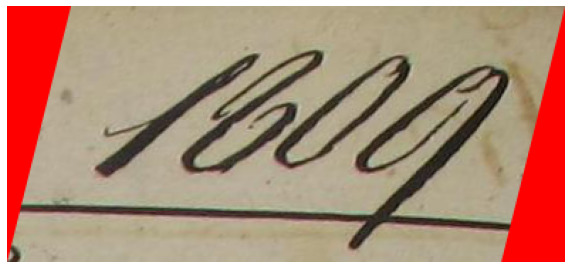

In [6]:
import matplotlib.pyplot as plt
plot_img(dataset[20]['image'])

In [4]:
dataset.word_df.file.iloc[100]

'a01-003-01-03.png'

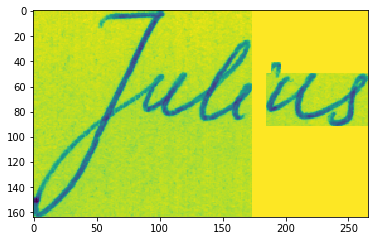

In [13]:
from skimage import io
import os
root_dir='/home/jupyter/tutorials/my_projects/word_recognition/words'
im = io.imread(os.path.join(root_dir, dataset.get_folder(dataset.word_df.file.iloc[810]), dataset.word_df.file.iloc[810]))
plt.imshow(im)

In [14]:
os.mkdir('/home/jupyter/tutorials/my_projects/word_recognition/words/deslanted')
save_path = '/home/jupyter/tutorials/my_projects/word_recognition/words/deslanted'
for i in range(len(dataset)):
    if not os.path.exists(os.path.join(save_path, dataset.get_folder(dataset.word_df.file.iloc[i]))):
        os.makedirs(os.path.join(save_path, dataset.get_folder(dataset.word_df.file.iloc[i])))
    im  = dataset[i]['image']
    io.imsave(os.path.join(save_path, dataset.get_folder(dataset.word_df.file.iloc[i]), dataset.word_df.file.iloc[i]), im)

/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/jupyter/tutorials/my_projects/word_recognition/words/deslanted/a02/a02-120/a02-120-10-04.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/jupyter/tutorials/my_projects/word_recognition/words/deslanted/b03/b03-114/b03-114-03-01.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/jupyter/tutorials/my_projects/word_recognition/words/deslanted/b04/b04-147/b04-147-00-06.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/jupyter/tutorials/my_projects/word_recognition/words/deslanted/b05/b05-055/b05-055-04-10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anacond

array([[247, 248, 249, ..., 255, 255, 255],
       [247, 244, 248, ..., 255, 255, 255],
       [249, 250, 248, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 247, 248, 248],
       [255, 255, 255, ..., 244, 247, 244],
       [255, 255, 255, ..., 248, 248, 244]], dtype=uint8)